# Análisis de salarios en Ciencia de Datos en el 2023

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Limpieza de datos con Python:

### Carga de datos e información del archivo a ser utilizado

Se consulto la forma de consumir un archivo en una sola variable debido a problemas anteriores en el nombre de mi carpeta, que contenia espacios.
Esto también sirve para especificar los sepraradores y el header.
https://stackoverflow.com/questions/66036273/pandas-read-csv-not-reading-raw-string

In [25]:
# carga del dataset a ser utilizado
ruta_csv = r'\ds_salaries.csv'  #definir ruta del archivo - Se agrega el archivo al repo del exámen ds_salaries.csv
df_ds_salaries= pd.read_csv(ruta_csv)
# Se verifica existencia de valores nulls
info = df_ds_salaries.info()  
# Verificación de duplicados 
duplicados = df_ds_salaries.duplicated()
df_duplicados = df_ds_salaries[duplicados]
info_duplicados = df_duplicados.shape
# Consulta duplicados
print(f'\nVerificación de duplicados: {info_duplicados}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB

Verificación de duplicados: (1171, 11)


Para eliminar duplicados como dice el ejercicio, se asume que los datos son una agrupación de salario de personas, ya que visualizando los datos, se puede entender que provienen de una plataforma de carga de salarios individuales.

In [30]:
# Se eliminan duplicados
df_ds_salaries.drop_duplicates(inplace=True)

# Funciones en clases de DataCamp, lambda/apply

df_ds_salaries[['experience_level', 'employment_type', 'job_title', 
                               'salary_currency', 'employee_residence', 
                               'company_location', 'company_size']] = \
df_ds_salaries[['experience_level', 'employment_type', 'job_title', 
                               'salary_currency', 'employee_residence', 
                               'company_location', 'company_size']].apply(
    lambda x: x.astype(str).str.upper().str.strip() # Convertir a mayúsculas y elimnas espacios al inicio y final de cada registro
)

display(df_ds_salaries) # Validación de cambios realizados
# Consulta nuevamente información del dataframe para validar nulls
df_ds_salaries.info() # Resultado: No se registran nullos

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,PRINCIPAL DATA SCIENTIST,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML ENGINEER,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML ENGINEER,25500,USD,25500,US,100,US,S
3,2023,SE,FT,DATA SCIENTIST,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,DATA SCIENTIST,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,DATA SCIENTIST,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,PRINCIPAL DATA SCIENTIST,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,DATA SCIENTIST,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,BUSINESS DATA ANALYST,100000,USD,100000,US,100,US,L


<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


Para los casos donde los salarios no están dentro de los parámetros normales decidí reemplazar estos valores por el máximo. Ésto se puede reemplazar también por el promedio.

In [48]:
# Función para detectar y reemplazar salarios anómalos
def detectar_anomalias(grupo):
    # Calcular cuartiles y IQR
    Q1 = grupo['salary'].quantile(0.25)
    Q3 = grupo['salary'].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular límites superior e inferior
    limite_superior = Q3 + 1.5 * IQR
    limite_inferior = Q1 - 1.5 * IQR

    # Reemplazar valores anómalos con la media del grupo
    media = grupo['salary'].mean()
    grupo['salary'] = grupo['salary'].where(grupo['salary'] <= limite_superior, media)
    grupo['salary'] = grupo['salary'].where(grupo['salary'] >= limite_inferior, media)

    # Aplicar redondeo sin decimales para estandarización
    grupo['salary'] = grupo['salary'].round(0).astype(int) 

    return grupo 

# Aplicar la función a cada grupo definido por experiencia y rol.
df_ds_salaries = df_ds_salaries.groupby(['experience_level', 'job_title'], as_index=False).apply(detectar_anomalias).reset_index(drop=True)

## 2. Exploración de datos con Python:

### Univariadas

### Gráfico 1: Salario por Nivel de Experiencia

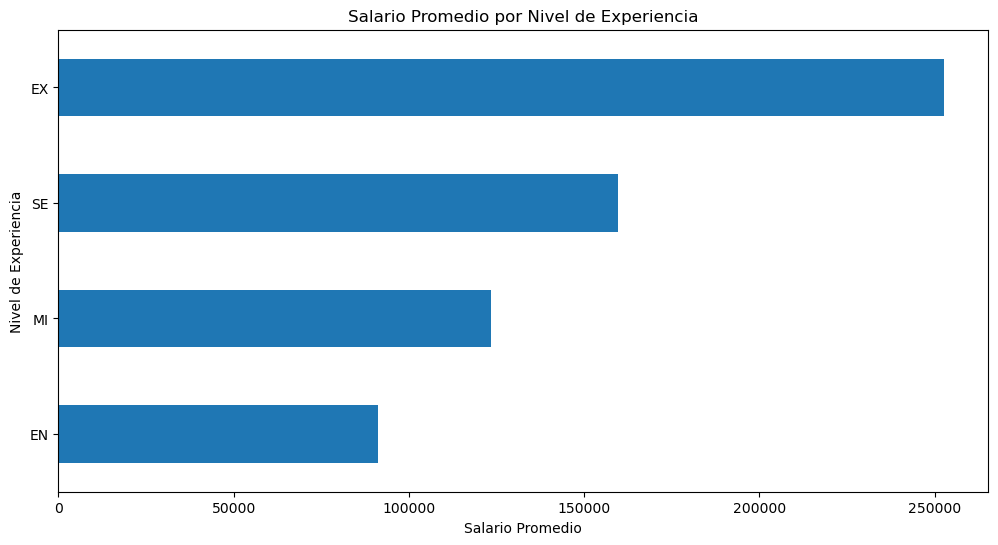

In [75]:
avg_salary_by_job = df_ds_salaries.groupby('experience_level')['salary'].mean().sort_values()
plt.figure(figsize=(12, 6))
avg_salary_by_job.plot(kind='barh')
plt.title('Salario Promedio por Nivel de Experiencia')
plt.xlabel('Salario Promedio')
plt.ylabel('Nivel de Experiencia')
plt.show()

### Gráfico 2: Distriución del Tamaño de la Empresa

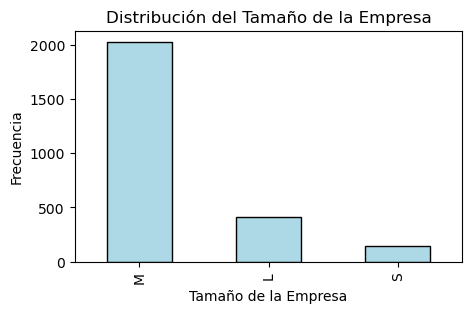

In [65]:
plt.figure(figsize=(5, 3))
df_ds_salaries['company_size'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribución del Tamaño de la Empresa')
plt.xlabel('Tamaño de la Empresa')
plt.ylabel('Frecuencia')
plt.show()

#Obs: el gráfico sugiere que la mayoría de los empleados del ára de data science trabajan en empresas medianas, en segundo lugar empresas grandes y en tercer lugar empresas pequeñas

### Multivariadas

### Gráfico 1. Salarios por Nivel de Experiencia

<Figure size 500x300 with 0 Axes>

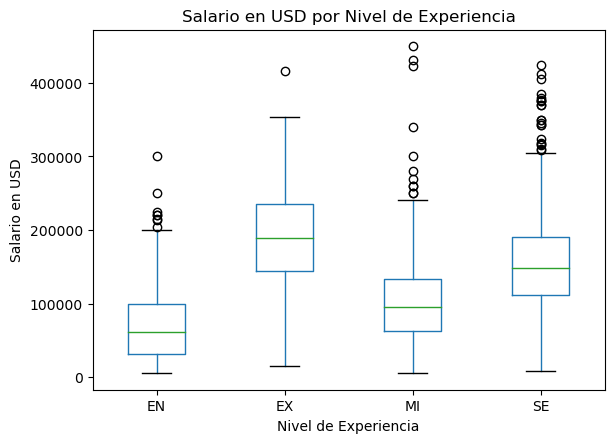

In [71]:
plt.figure(figsize=(5, 3))
df_ds_salaries.boxplot(column='salary_in_usd', by='experience_level', grid=False)
plt.title('Salario en USD por Nivel de Experiencia')
plt.suptitle('')  #remover el título automático de pandas
plt.xlabel('Nivel de Experiencia')
plt.ylabel('Salario en USD')
plt.show()

# Obs: los puestos Executive y Senior tienen los mejores salarios. Los salarios entry son los peores pagados, pero no hay mucha dispersión. 
# Podemos ver que hay mucha variabilidad en los puestos Executive, es decir, no todos reciben salarios altos o bajos.



### Gráfico 2. Salarios por tamaño de la empresa

<Figure size 1000x600 with 0 Axes>

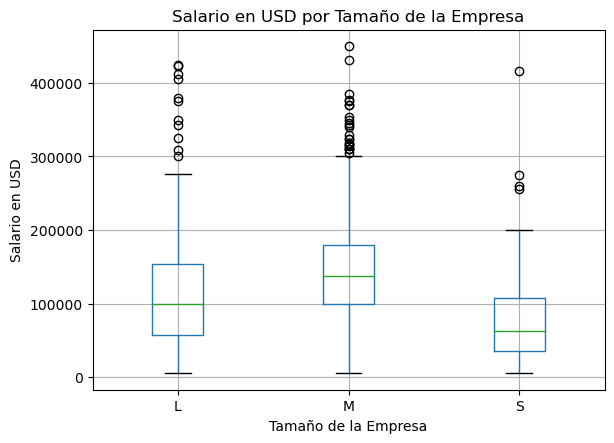

In [73]:
plt.figure(figsize=(10, 6))
df_ds_salaries.boxplot(column='salary_in_usd', by='company_size', grid=False)
plt.title('Salario en USD por Tamaño de la Empresa') #establecer titulo
plt.suptitle('')  #remover el título automático de pandas
plt.xlabel('Tamaño de la Empresa') #nombre del eje x
plt.ylabel('Salario en USD') #nombre del eje y
plt.grid(True) #agregar cuadriculas
plt.show() #mostrar grafico

#Analisis: Los salarios de empresas medianas tienen una distribucion salarial mas alta que las empresas grandes y pequeñas y tienen bastantes outliers. 
# En las empresas grandes tambien se observan outliers.Pocos casos de salarios altos en empresas pequeñas.

## Análisis adicional

In [78]:
#estadisticas descriptivas
resumen = df_ds_salaries['salary_in_usd'].describe() # medidas de tendencia central de la variable númerica "salary_in_usd".

IQR = resumen.loc['75%'] - resumen.loc['25%'] #calculo del IQR. Esta métrica nos indica que tan disperso estan los valores de la mediana.
print("Resumen estadístico general de salarios en dólares:")
print(resumen) #imprimir resumen

print("\nRango Intercuartílico (IQR):") #imprimir el IQR
print(IQR)

#Obs: al imprimir el resultado, podemos concluir de que el promedio de salarios es de $ 133.409. La mediana sería el valor del 50% ($130.000). 
# También podemos decir de que el 25% de los salarios está por debajo del $84.975 y el 75% por debajo de $175.000

Resumen estadístico general de salarios en dólares:
count      2584.000000
mean     133409.280186
std       67136.837329
min        5132.000000
25%       84975.000000
50%      130000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

Rango Intercuartílico (IQR):
90025.0


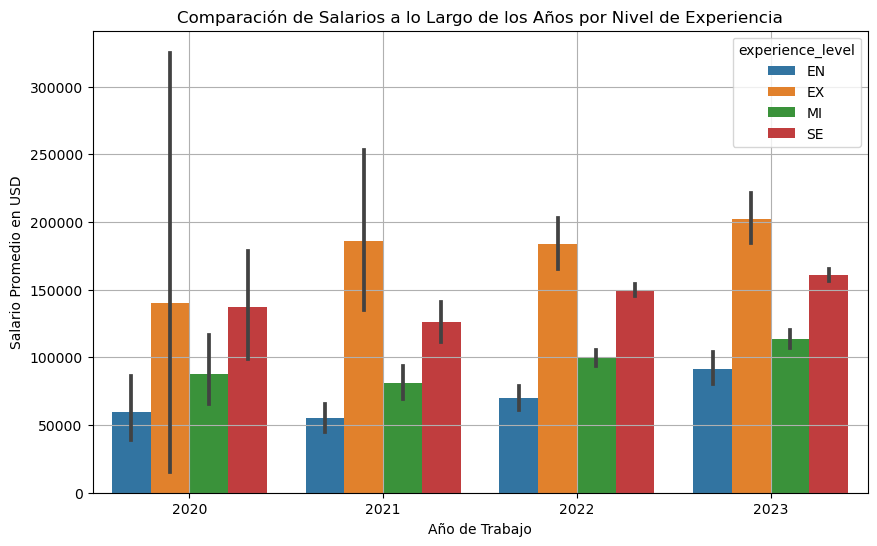

In [81]:
#Identificación de tendencias
# Gráfico de barras para comparar los salarios a lo largo de los años según el nivel de experiencia

salary_by_year_exp = df_ds_salaries.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean().reset_index() #agrupar la media salarial por año y por nivel de experiencia

plt.figure(figsize=(10, 6)) #agregar figura
sns.barplot(x='work_year', y='salary_in_usd', hue='experience_level', data=df_ds_salaries) #crear grafico de barras, agregar leyenda como nivel de experiencia (hue)

# Añadir títulos y etiquetas
plt.title('Comparación de Salarios a lo Largo de los Años por Nivel de Experiencia')
plt.xlabel('Año de Trabajo')
plt.ylabel('Salario Promedio en USD')
plt.grid(True)
plt.show()

#Obs: podemos observar mediante este gráfico que desde el 2020 al 2023 hubo aumentos de salarios para data science para todos los niveles de experiencia. 
# Se destaca el gran aumento que tuvieron los puestos ejecutivos y de entry level Lo que podría motivar a los inexpertos a volcarse al area sin tener experiencia alguna. 
# Se observa también que hay un comportamiento inusual, el aumento salarial de los entry, seniors y mid no fue tanto en comparación a los executive, que son los mejores pagados.
# Se oberva en el 2020 hubo un disparo salarial para lo más expertos, llegando a los 300.000 USD.

# Complementos utilizados

- https://app.datacamp.com/learn/courses/understanding-data-visualization
- Git del profesor del Bootcamp
- https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.read_csv.html